# Strong Lensing 

This is an example notebook for the Strong Lensing Challenge. In this notebook, we present a simple CNN model implemented using the PyTorch library to solve the task of binary classification of strong lensing images. We then implement an unsupervised model for anomaly detection which is the primary objective of this challenge.

### Dataset

The Dataset consists of two classes, strong lensing images with no substructure and strong lensing images with substructure. Considering the samples with substructure to be outliers, you are required to train an unsupervised model on a set of strong lensing images with no substructure to solve the task of anomaly detection.

Link to the Dataset: https://github.com/ML4SCI-SLC/SLC_Data

### Evaluation Metrics

* Distribution of Reconstruction Loss,
* ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)   

The model performance will be tested on the hidden test dataset based on the above metrics.

### Instructions for using the notebook

1. Use GPU acceleration: (Edit --> Notebook settings --> Hardware accelerator --> GPU)
2. Run the cells: (Runtime --> Run all)

> **_NOTE:_**  This notebook contains a section for a supervised approach for binary classification, this is only for the sake of intuition, and you are required to work only on the unsupervised model.

In [1]:
# Get the Dataset
!git clone https://github.com/ML4SCI-SLC/SLC_Data.git
%cd SLC_Data

fatal: destination path 'SLC_Data' already exists and is not an empty directory.
/Users/sayebms1/my_github/Gravitational_Lensing/SLC_Data


## 1. Binary Classification using a Supervised Model

### 1.1 Data Visualization and Preprocessing 

Samples with substructure: 


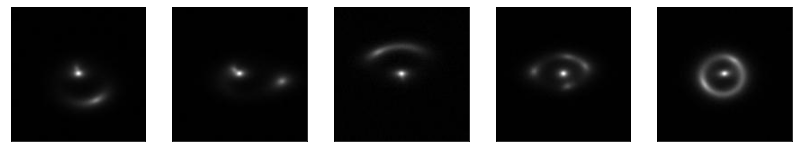

Samples with no substructure: 


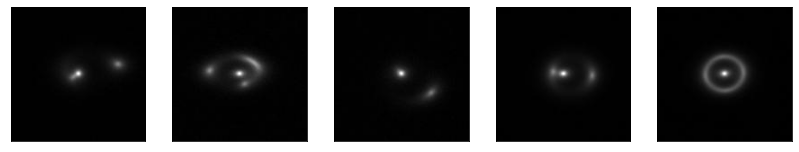

In [12]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

path_sub = './lenses/sub' # Path to samples with substructure 
files_sub = [os.path.join(path_sub, f) for f in os.listdir(path_sub) if f.endswith(".jpg")]
random.shuffle(files_sub)

# Number of samples to display per class
n = 5

# Plot the samples with substructure 
print('Samples with substructure: ')
i = 1
plt.rcParams['figure.figsize'] = [14, 14]
for image in files_sub[:n]:
    ax = plt.subplot(2,n,i)
    plt.imshow(cv2.imread(image,0), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()
    
path_nosub = './lenses/no_sub' # Path to samples with no substructure 
files_nosub = [os.path.join(path_nosub, f) for f in os.listdir(path_nosub) if f.endswith(".jpg")]
random.shuffle(files_nosub)

# Plot the samples with no substructure 
print('Samples with no substructure: ')
i = 1
for image in files_nosub[:n]:
    ax = plt.subplot(2,n,i+n)
    plt.imshow(cv2.imread(image,0), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

In [21]:
# Data augmentation 
transform = transforms.Compose([transforms.Grayscale(),
                                        transforms.Resize((150, 150)),
                                        transforms.RandomAffine(degrees=(0,90), translate=(0.2,0.2)),
                                        transforms.ToTensor()])

batch_size = 100
data_path = './lenses' # Path to input data
data = datasets.ImageFolder(data_path, transform = transform)


print("Classes: " + str(data.class_to_idx))
data_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)

x = []
y = []
for samples, labels in data_loader:
    x.append(samples.numpy())
    y.append(labels.numpy())
x = np.asarray(x)
y = np.asarray(y)

print('Data Processed!')
print('Shape of the Data: ' + str(x.shape))
print('Shape of the labels: ' + str(y.shape))

Classes: {'no_sub': 0, 'sub': 1}
Data Processed!
Shape of the Data: (90, 100, 1, 150, 150)
Shape of the labels: (90, 100)


In [20]:
print (x.shape)
p

(90, 100, 1, 150, 150)

Classes: {'no_sub': 0, 'sub': 1}


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

### 1.2 Defining a CNN Model

You may refer to this [article](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148) to learn about Convolutional Neural Networks (CNN)

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# Define the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(1, 16, (11,11), stride=3)
        self.conv2 = nn.Conv2d(16, 32, (11,11), stride=3)
        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.flat = nn.Flatten()
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = self.flat(x)
        x = self.batchnorm1(x)
        x = self.fc1(x)
        x = self.batchnorm2(x)
        x = self.fc2(x)
        return x
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

### 1.3 Training the CNN Model

In [ ]:
# Hold-out validation
split = 0.8
x_train = x[:int(x.shape[0]*split)]
y_train = y[:int(x.shape[0]*split)]

n_epochs = 10 # Number of Epochs
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)

# Train the model
pbar = tqdm(range(1, n_epochs+1))
loss_array = []
for epoch in pbar:
    train_loss = 0.0
    train_acc = 0.0
    for i in range(len(x_train)):
        samples = torch.tensor(x_train[i], dtype=torch.float32, device=device)
        labels = torch.tensor(y_train[i], dtype=torch.long, device=device)
        optimizer.zero_grad()
        outputs = model(samples)
        _, preds = torch.max(model(samples).data, 1)
        correct = (preds == labels).float().sum()
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += correct/batch_size

    train_loss = train_loss/len(data)
    loss_array.append(train_loss)
    
    pbar.set_postfix({'Epoch': epoch, 'Training Loss': train_loss, 'Training Accuracy': train_acc.cpu().numpy()/x_train.shape[0]})
    torch.save(model, 'CNN_model.pth')
    
# Plot the training loss
plt.rcParams['figure.figsize'] = [7, 5]
plt.plot(loss_array)
plt.title('Training Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### 1.4 Testing the CNN Model

You may refer to this [article](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152) to learn about AUC ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Validation samples
x_val = x[int(x.shape[0]*split):].reshape(-1,1,150,150)
y_val = y[int(x.shape[0]*split):].reshape(-1,1)

val_data = torch.from_numpy(x_val)
if torch.cuda.is_available():
  val_data = val_data.cuda()
probs = torch.nn.functional.softmax(model(val_data), dim=1)
auc_score = roc_auc_score(y_val, probs[:,-1].cpu().detach().numpy())

print('Validation AUC: ' + str(auc_score))

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_val, probs[:,-1].cpu().detach().numpy())
roc_auc = auc(fpr, tpr)

# Plot the AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right", prop={"size":10})
plt.show()

While this notebook presents a supervised approach, the goal of this challenge is to design and implement an unsupervised machine learning methodology for anomaly detection. We use the distribution of reconstruction loss and the area under the ROC curve (AUC) for Classification based on the reconstruction loss as metrics for evaluating the performance of the unsupervised model.

You must only submit the unsupervised implementation. The use of any supervised models will not be considered for evaluation. 

## 2. Anomaly Detection using an Unsupervised Model 

### 2.1 Preparing the Dataset

In [ ]:
print("Classes: " + str(data.class_to_idx))
data_loader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle=True)

no_sub = []
sub = []
for samples, labels in data_loader:
    if labels[0] == 0:
        no_sub.append(samples.numpy()[0])
    else:
        sub.append(samples.numpy()[0])
no_sub = np.asarray(no_sub)
sub = np.asarray(sub)

no_sub = no_sub.reshape(batch_size,-1,1,150,150)
sub = sub.reshape(batch_size,-1,1,150,150)

# Hold-out validation
split = 0.8
x_train = no_sub[:int(no_sub.shape[0]*split)]

print("Shape of no substructure data: " + str(no_sub.shape))
print("Shape of substructure data: " + str(sub.shape))

### 2.2 Defining an RBM model

You may refer to this [article](https://medium.com/datadriveninvestor/an-intuitive-introduction-of-restricted-boltzmann-machine-rbm-14f4382a0dbb) to learn about Restricted Boltzmann Machine (RBM)

In [ ]:
# Define the model
class RBM(nn.Module):

    def __init__(self, n_vis=22500, n_hid=1000, k=1):
        super(RBM, self).__init__()
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def visible_to_hidden(self, v):
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v):
        v_term = torch.matmul(v, self.v.t())
        w_x_h = F.linear(v, self.W, self.h)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, v):
        h = self.visible_to_hidden(v)
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)
        return v, v_gibb, h

model = RBM().to(device)

### 2.3 Training the RBM model

In [ ]:
n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 2e-3, epochs=n_epochs, steps_per_epoch=x_train.shape[0])

# Train the model
loss_array = []
for epoch in tqdm(range(1, n_epochs+1)):
    train_loss = 0.0
    
    for i in range(x_train.shape[0]):

        data = torch.from_numpy(x_train[i])
        if torch.cuda.is_available():
          data = data.cuda()
        optimizer.zero_grad()
        v, v_gibbs, hidden = model(data.view(-1, 22500))
        loss = model.free_energy(v) - model.free_energy(v_gibbs)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    # print avg training statistics
    train_loss = train_loss/x_train.shape[0]
    loss_array.append(train_loss)
    
# Plot the training loss
plt.rcParams['figure.figsize'] = [7, 5]
plt.plot(loss_array)
plt.title('Training Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### 2.4 Testing the RBM Model

You may refer to this [article](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152) to learn about AUC ROC Curve

Additionally, you may also refer to this [article](https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098) to learn how the AUC score is calculated in the case of Anomaly Detection

In [ ]:
import math
import seaborn as sns
sns.set()

# Validation samples
x_test1 = no_sub[int(no_sub.shape[0]*split):]
x_test2 = sub[int(sub.shape[0]*split):]

# Get the reconstructed samples
out1 = []
out2 = []
for i in range(x_test1.shape[0]):

        data1 = torch.from_numpy(x_test1[i])
        data2 = torch.from_numpy(x_test2[i])
        if torch.cuda.is_available():
          data1 = data1.cuda()
          data2 = data2.cuda()
        v1, v_gibbs1, hidden1 = model(data1.view(-1, 22500))
        v2, v_gibbs2, hidden2 = model(data2.view(-1, 22500))
        out1.append(v_gibbs1.cpu().detach().numpy())
        out2.append(v_gibbs2.cpu().detach().numpy())

no_sub_recon = np.asarray(out1)
sub_recon = np.asarray(out2)

x_test1 = x_test1.reshape(-1,22500)
x_test2 = x_test2.reshape(-1,22500)
no_sub_recon = no_sub_recon.reshape(-1,22500)
sub_recon = sub_recon.reshape(-1,22500)

# Calculate reconstruction loss
losses1 = []
losses2 = []
for i in range(x_test1.shape[0]):
    
    criteria = nn.MSELoss()
    losses1.append(criteria(torch.from_numpy(x_test1[i]), torch.from_numpy(no_sub_recon[i])))
    losses2.append(criteria(torch.from_numpy(x_test2[i]), torch.from_numpy(sub_recon[i])))

losses1 = np.asarray(losses1)
losses2 = np.asarray(losses2)

# Plot the distribution of reconstruction loss
w = 0.0005
n1 = math.ceil((losses1.max() - losses1.min())/w)
n2 = math.ceil((losses2.max() - losses2.min())/w)

sns.distplot(losses2,label='sub',kde=0,norm_hist=0, color="r", bins=n2)
sns.distplot(losses1,label='no_sub',kde=0,norm_hist=0, color="g", bins=n1)
plt.legend()
plt.xlabel('MSELoss')
plt.ylabel('Population')
plt.title('Distribution of Reconstruction Loss for test samples')
plt.show()

y_ts1 = []
for i in range(losses1.shape[0]):
    y_ts1.append(0)
y_ts1 = np.asarray(y_ts1)
y_ts2 = []
for i in range(losses2.shape[0]):
    y_ts2.append(1)
y_ts2 = np.asarray(y_ts2)

x_ts = np.concatenate((losses1,losses2)).reshape(-1,1)
y_ts = np.concatenate((y_ts1,y_ts2))

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_ts, x_ts)
roc_auc = auc(fpr, tpr)

# Plot the AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right", prop={"size":10})

The AUC score is very low since we have trained a basic RBM model which is chosen for the sole purpose of demonstration. We expect your model to have a high AUC score. One interesting approach could be the use of autoencoders.

## Submission Guidelines 

* You are required to submit a Google Colab Jupyter Notebook clearly showing your implementation along with the evaluation metrics (Distribution of Reconstruction Loss, ROC curve, and AUC score) for the training and validation data.
* You must also submit the final trained model, including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. )
* You can use this example notebook as a template for your work. 
* As mentioned earlier, you are only required to submit the unsupervised implementation.  

> **_NOTE:_**  You are free to use any ML framework such as PyTorch, Keras, TensorFlow, etc.